# Extract all orders from markdown blackbooks

In [ ]:
"""
Blackbook Extraction — ORDER LEVEL (All Files)
Chunking ≈ 5000 chars, extends to next Effective boundary
Issued year priority:
Filed > Dated > Approved > Effective
"""

import re
from pathlib import Path
from typing import List, Optional
import pandas as pd
from tqdm import tqdm
from pydantic import BaseModel
from langchain_openai import ChatOpenAI


# ============================================================
# CONFIG
# ============================================================

LLM_MODEL = "gpt-5-mini"

INPUT_DIR = Path(
    "/Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/blackbooks/md_format_clean"
)

OUTPUT_FILE = Path(
    "/Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/order_extraction/extracted_orders_all_files.xlsx"
)


# ============================================================
# SCHEMA
# ============================================================

class OrderEntry(BaseModel):
    order_title: str
    filed_date: Optional[str] = None
    dated_date: Optional[str] = None
    approved_date: Optional[str] = None
    effective_date: Optional[str] = None


class OrdersList(BaseModel):
    orders: List[OrderEntry]


# ============================================================
# CHUNKING (~5000 chars, extend to next Effective boundary)
# ============================================================

def chunk_page_extend_to_effective(text: str):

    text = text.replace("\r\n", "\n").replace("\r", "\n")

    effective_pattern = re.compile(
        r"Effective\s*:?\s*"
        r"(?:\d{1,2}/\d{1,2}/\d{4}"
        r"|[A-Za-z]+\s+\d{1,2},?\s+\d{4})",
        re.IGNORECASE
    )

    TARGET_SIZE = 5000
    MAX_EXTENSION = 15000  # safety cap

    chunks = []
    i = 0
    n = len(text)

    while i < n:

        tentative_end = min(i + TARGET_SIZE, n)

        match = effective_pattern.search(text, tentative_end)

        if match:
            end = match.end()

            # prevent runaway large chunk
            if end - i > MAX_EXTENSION:
                end = tentative_end
        else:
            end = n

        chunk = text[i:end].strip()

        if chunk:
            chunks.append(chunk)

        i = end

    return chunks


# ============================================================
# PROMPT
# ============================================================

def build_prompt(chunk: str) -> str:
    return f"""
Extract complete court orders.

An order usually contains a heading/title, and at least one date. You might retrieve an order that has no date associated.

Note that an order is literally any paragraph that has a date after, such as 'AMENDING RULES 47.1, 48, AND 79, RULES OF PROCEDURE FOR THE JUVENILE COURT, ON A PERMANENT BASIS
Filed: 12/12/2019
Effective 12/12/2019'

Additionally extract if present:
• Filed: date
• Dated: date
• Approved: date

Return structured output only.

TEXT:
{chunk}
""".strip()


# ============================================================
# ISSUED YEAR LOGIC (DETERMINISTIC)
# ============================================================

def extract_year(date_str):
    if not date_str:
        return None
    match = re.search(r"\d{4}", str(date_str))
    return int(match.group()) if match else None


def compute_issued_year(row):
    for field in ["filed_date", "dated_date", "approved_date", "effective_date"]:
        year = extract_year(row.get(field))
        if year:
            return year
    return None


# ============================================================
# MAIN
# ============================================================

def main():

    print("🚀 Starting extraction (all files)")

    if not INPUT_DIR.exists():
        print("❌ Input directory not found:", INPUT_DIR)
        return

    md_files = sorted(INPUT_DIR.glob("*.md"))

    if not md_files:
        print("❌ No markdown files found.")
        return

    print(f"Found {len(md_files)} markdown files.")

    llm = ChatOpenAI(
        model=LLM_MODEL,
    )

    structured_llm = llm.with_structured_output(OrdersList)

    # --------------------------------------------------
    # PRECOMPUTE TOTAL CHUNKS
    # --------------------------------------------------

    file_chunks_map = {}
    total_chunks = 0

    for f in md_files:
        text = f.read_text(encoding="utf-8", errors="ignore")
        text = re.sub(r"<!--.*?-->", "", text, flags=re.S)
        chunks = chunk_page_extend_to_effective(text)

        file_chunks_map[f] = chunks
        total_chunks += len(chunks)

    print(f"Total chunks to process: {total_chunks}")

    # --------------------------------------------------
    # PROCESS CHUNKS WITH GLOBAL tqdm
    # --------------------------------------------------

    all_rows = []

    with tqdm(total=total_chunks, desc="Chunks") as pbar:

        for f, chunks in file_chunks_map.items():

            if not chunks:
                tqdm.write(f"⚠️ No chunks in {f.name}")
                continue

            for chunk in chunks:

                try:
                    result = structured_llm.invoke(build_prompt(chunk))
                    rows = [o.model_dump() for o in result.orders]

                    for r in rows:
                        r["source_file"] = f.name

                    all_rows.extend(rows)

                except Exception as e:
                    tqdm.write(f"❌ LLM ERROR in {f.name}: {e}")

                pbar.update(1)

            # --------------------------------------------------
            # SAVE AFTER EACH FILE
            # --------------------------------------------------

            if all_rows:

                df = pd.DataFrame(all_rows)

                df["issued_year"] = df.apply(compute_issued_year, axis=1)

                df["order_title_norm"] = (
                    df["order_title"]
                    .str.lower()
                    .str.replace(r"\s+", " ", regex=True)
                    .str.strip()
                )

                df = df.drop_duplicates(
                    subset=["order_title_norm", "effective_date"],
                    keep="first",
                ).drop(columns=["order_title_norm"])

                df.to_excel(OUTPUT_FILE, index=False)

                tqdm.write(
                    f"💾 Saved after {f.name} "
                    f"({len(df)} total orders so far)"
                )

    print(f"\n✅ Finished processing all chunks.")
    print(f"Final output saved to: {OUTPUT_FILE}")



if __name__ == "__main__":
    main()


# Extract bodies of rules from orders

In [2]:
"""
Blackbook Extraction — BODY OF RULE LEVEL
Splits previously extracted orders into one row per body of rules
- Uses project-relative paths
- Handles 1, 2, 3, 4+ rule bodies
- Reattaches bracket codes and dates to every row
- Deterministic fallback if LLM fails
- MULTITHREADED for faster processing
- EXTRACTS body of rules name to new column
"""
from pathlib import Path
from typing import List
import pandas as pd
from pydantic import BaseModel
from tqdm import tqdm
from langchain_openai import ChatOpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

# ============================================================
# CONFIG (PROJECT-RELATIVE)
# ============================================================
LLM_MODEL = "gpt-5-mini"
MAX_WORKERS = 500

BASE_DIR = Path.cwd().parent  

INPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_orders_all_files.xlsx"
OUTPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"

# ============================================================
# STRUCTURED OUTPUT SCHEMA
# ============================================================
class SplitBody(BaseModel):
    body_text: str
    body_name: str  # e.g., "Arizona Rules of Civil Procedure"

class SplitBodiesList(BaseModel):
    bodies: List[SplitBody]

# ============================================================
# PROMPT
# ============================================================
def build_split_prompt(order_title: str) -> str:
    return f"""
Split this court order into separate rows, ONE ROW PER DISTINCT BODY OF RULES.

For EACH body, you must provide:
1. body_text: The full text of that row (with order number, rules, bracket code, dates)
2. body_name: JUST the name of the rule system (e.g., "Arizona Rules of Civil Procedure")

CRITICAL RULE for body_text:
Each row must include:
- The order number (e.g., "(13)")
- The specific rules for that body
- The bracket code (e.g., [R-18-0008])
- ALL dates (Filed/Effective/Dated/Approved)

CRITICAL RULE for body_name:
Extract ONLY the rule system name, such as:
- "Arizona Rules of Civil Procedure"
- "Arizona Rules of Criminal Procedure"
- "Arizona Rules of Evidence"
- "Rules of Evidence"
- "Arizona Rules of Procedure for the Juvenile Court"
- "Arizona Rule of Procedure for Eviction Actions"
- "Rules of the Supreme Court"

SPLITTING TRIGGERS:
- Semicolons separating rule systems
- "AND [RULE SYSTEM NAME]" introducing a new system
- Any new distinct named rule system

DO NOT SPLIT when "and" just connects rule numbers in the same system.

EXAMPLE (REQUIRED FORMAT):
Input: (13) ORDER AMENDING RULES OF EVIDENCE 1001, 1002, 1004, 1006, 1007, 1008; ARIZONA RULES OF CRIMINAL PROCEDURE 15.1, 15.2, 15.3; ARIZONA RULES OF PROCEDURE FOR THE JUVENILE COURT 16, 44, 73; and ARIZONA RULE OF PROCEDURE FOR EVICTION ACTIONS 10 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019

Expected output (4 separate bodies):
Body 1: 
  body_text: "(13) ORDER AMENDING RULES OF EVIDENCE 1001, 1002, 1004, 1006, 1007, 1008; [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Rules of Evidence"

Body 2:
  body_text: "ARIZONA RULES OF CRIMINAL PROCEDURE 15.1, 15.2, 15.3 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Arizona Rules of Criminal Procedure"

Body 3:
  body_text: "ARIZONA RULES OF PROCEDURE FOR THE JUVENILE COURT 16, 44, 73 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Arizona Rules of Procedure for the Juvenile Court"

Body 4:
  body_text: "ARIZONA RULE OF PROCEDURE FOR EVICTION ACTIONS 10 [R-18-0008] Filed: 08/28/2018 Effective: 01/01/2019"
  body_name: "Arizona Rule of Procedure for Eviction Actions"

NOW PROCESS:
{order_title}
""".strip()

# ============================================================
# PROCESSING FUNCTION
# ============================================================
def process_row(row_data):
    """Process a single row - this will be called in parallel"""
    idx, row = row_data
    
    # Each thread gets its own LLM instance
    llm = ChatOpenAI(model=LLM_MODEL)
    structured_llm = llm.with_structured_output(SplitBodiesList)
    
    try:
        result = structured_llm.invoke(
            build_split_prompt(row["order_title"])
        )
        
        bodies = [(b.body_text.strip(), b.body_name.strip()) for b in result.bodies]
        
        if not bodies:
            bodies = [(row["order_title"], "Unknown")]
            
    except Exception as e:
        # Fallback to original title on error
        bodies = [(row["order_title"], "Unknown")]
    
    # Create one row per body
    result_rows = []
    for body_text, body_name in bodies:
        new_row = row.to_dict()  # FIXED: Convert to dict
        new_row["order_title"] = body_text
        new_row["body_of_rules"] = body_name
        result_rows.append(new_row)
    
    return result_rows

# ============================================================
# MAIN
# ============================================================
def main():
    print("🚀 Starting rule-body extraction (MULTITHREADED)")
    
    if not INPUT_FILE.exists():
        print("❌ Input file not found:", INPUT_FILE)
        return
    
    df = pd.read_excel(INPUT_FILE)
    
    print(f"Processing {len(df)} orders with {MAX_WORKERS} workers...")
    
    all_rows = []
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Submit all tasks
        futures = {
            executor.submit(process_row, (idx, row)): idx 
            for idx, row in df.iterrows()
        }
        
        # Process results as they complete
        with tqdm(total=len(futures), desc="Orders") as pbar:
            for future in as_completed(futures):
                try:
                    result_rows = future.result()
                    all_rows.extend(result_rows)
                except Exception as e:
                    print(f"❌ Error processing row: {e}")
                
                pbar.update(1)
    
    final_df = pd.DataFrame(all_rows)
    
    # Reorder columns to put body_of_rules first
    if 'body_of_rules' in final_df.columns:
        cols = ['body_of_rules'] + [col for col in final_df.columns if col != 'body_of_rules']
        final_df = final_df[cols]
    
    print(f"\n📊 Columns: {list(final_df.columns)}")
    if 'body_of_rules' in final_df.columns:
        print(f"Sample body_of_rules values:\n{final_df['body_of_rules'].value_counts().head(10)}")
    
    # --------------------------------------------------------
    # DEDUPLICATION
    # --------------------------------------------------------
    final_df["rule_body_norm"] = (
        final_df["order_title"]
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    
    initial_count = len(final_df)
    
    final_df = final_df.drop_duplicates(
        subset=["rule_body_norm", "effective_date"],
        keep="first"
    ).drop(columns=["rule_body_norm"])
    
    duplicates_removed = initial_count - len(final_df)
    
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    final_df.to_excel(OUTPUT_FILE, index=False)
    
    print("\n✅ Finished.")
    print(f"Input rows: {len(df)}")
    print(f"Output rows: {len(final_df)}")
    print(f"Duplicates removed: {duplicates_removed}")
    print("Saved to:", OUTPUT_FILE)

if __name__ == "__main__":
    main()

🚀 Starting rule-body extraction (MULTITHREADED)
Processing 1999 orders with 500 workers...


Orders: 100%|██████████| 1999/1999 [00:52<00:00, 38.38it/s] 


📊 Columns: ['body_of_rules', 'order_title', 'filed_date', 'dated_date', 'approved_date', 'effective_date', 'source_file', 'issued_year']
Sample body_of_rules values:
body_of_rules
Rules of the Supreme Court                           486
Arizona Rules of Criminal Procedure                  339
Arizona Rules of Civil Procedure                     278
Arizona Rules of Procedure for the Juvenile Court    114
Arizona Rules of Civil Appellate Procedure            79
Arizona Rules of Family Law Procedure                 39
Uniform Rules of Practice of the Superior Court       26
Rules of Family Law Procedure                         25
Rules of Procedure for Special Actions                21
Arizona Rules of Evidence                             21
Name: count, dtype: int64

✅ Finished.
Input rows: 1999
Output rows: 2178
Duplicates removed: 1
Saved to: /Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/order_extraction/extracted_rule_bodies.xlsx


In [8]:
"""
Create robust issued_date column
Priority:
filed_date > dated_date > approved_date > effective_date
"""

from pathlib import Path
import pandas as pd
import re

# ============================================================
# CONFIG
# ============================================================

BASE_DIR = Path.cwd().parent  

INPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"
OUTPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"


# ============================================================
# DATE CLEANER
# ============================================================

def extract_date(text):
    """
    Extract a clean date string from messy text.
    Handles:
    - 01/01/2019
    - 1/1/78
    - January 1, 2019
    - January 1 2019
    """

    if pd.isna(text):
        return None

    text = str(text)

    # Pattern 1: numeric dates
    match_numeric = re.search(r"\d{1,2}/\d{1,2}/\d{2,4}", text)
    if match_numeric:
        return match_numeric.group(0)

    # Pattern 2: written month dates
    match_written = re.search(
        r"(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},?\s+\d{4}",
        text,
        re.IGNORECASE
    )
    if match_written:
        return match_written.group(0)

    return None


def parse_date(text):
    """
    Extract and convert to pandas datetime.
    """
    clean = extract_date(text)
    if not clean:
        return pd.NaT

    return pd.to_datetime(clean, errors="coerce")


# ============================================================
# MAIN
# ============================================================

def main():
    print("🚀 Creating robust issued_date column")

    df = pd.read_excel(INPUT_FILE)

    # Parse each date column safely
    for col in ["filed_date", "dated_date", "approved_date", "effective_date"]:
        if col in df.columns:
            df[col + "_parsed"] = df[col].apply(parse_date)
        else:
            df[col + "_parsed"] = pd.NaT

    # Priority logic
    df["issued_date"] = (
        df["filed_date_parsed"]
        .fillna(df["dated_date_parsed"])
        .fillna(df["approved_date_parsed"])
        .fillna(df["effective_date_parsed"])
    )

    # Extract year
    df["issued_year"] = df["issued_date"].dt.year

    # Optional sanity filter (avoid 1900 garbage, etc.)
    df.loc[df["issued_year"] < 1900, "issued_date"] = pd.NaT
    df.loc[df["issued_year"] < 1900, "issued_year"] = pd.NA

    # Clean temporary columns
    df = df.drop(columns=[
        "filed_date_parsed",
        "dated_date_parsed",
        "approved_date_parsed",
        "effective_date_parsed"
    ])

    df.to_excel(OUTPUT_FILE, index=False)

    print("✅ Done")
    print("Rows:", len(df))
    print("Missing issued_date:", df["issued_date"].isna().sum())


if __name__ == "__main__":
    main()


🚀 Creating robust issued_date column
✅ Done
Rows: 2178
Missing issued_date: 11


# Create an "Issued_Date" column

# Categorize (local, statewide, statewide trial)

In [14]:
"""
Step 4 + Step 5 — Regex ("local" anywhere) + LLM (catch county-specific locals)

Definitions:

Regex:
- Local Rule (Regex) = 1 iff "local" appears anywhere in order_title
- Statewide Rule (Regex) = exact opposite
- Statewide Trial Court Rule (Regex) = 1 iff:
    Statewide Rule (Regex) == 1
    AND NOT "Rule(s) of the Supreme Court"
    AND NOT "Appellate" unless also "Superior"

LLM:
- Local Rule (LLM) = model classification of local vs statewide
  BUT hard override: if "local" appears anywhere => Local=1 (match definition)
- Statewide Rule (LLM) = exact opposite
- Statewide Trial Court Rule (LLM) computed deterministically from Statewide Rule (LLM)
"""

from pathlib import Path
import pandas as pd
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# ============================================================
# CONFIG
# ============================================================

LLM_MODEL = "gpt-5-mini"
MAX_WORKERS = 500  # safe; increase gradually if your rate limits allow

BASE_DIR = Path.cwd().parent
INPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies.xlsx"
OUTPUT_FILE = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies_llm_regex.xlsx"

# ============================================================
# LLM SCHEMA
# ============================================================

class LocalClassification(BaseModel):
    is_local: int  # must be 0 or 1


# ============================================================
# LLM PROMPT
# ============================================================

def build_prompt(text: str) -> str:
    return f"""
Classify whether this rule entry is LOCAL or STATEWIDE.

Return:
is_local: 1 or 0

Guidance:
- LOCAL = applies to a specific county/city/court location (e.g., "Maricopa County Superior Court",
  "Pima County", "Phoenix Municipal Court", "Yavapai County Justice Court", etc.)
- STATEWIDE = applies across Arizona statewide (e.g., "Arizona Rules of Civil Procedure",
  "Arizona Rules of Criminal Procedure", "Rules of Evidence", etc.)

Important examples:
- "Rules of Practice for the Maricopa County Superior Court" => LOCAL (1)
- "Arizona Rules of Civil Procedure" => STATEWIDE (0)

TEXT:
{text}
""".strip()


# ============================================================
# STEP 5 HELPER
# ============================================================

def compute_statewide_trial_court_rule(df: pd.DataFrame, statewide_col: str, out_col: str) -> None:
    """
    Statewide Trial Court Rule = 1 iff:
      statewide_col == 1
      AND body_of_rules does NOT contain "Rule(s) of the Supreme Court"
      AND (body_of_rules does not contain "Appellate" OR body_of_rules contains BOTH "Appellate" and "Superior")
    """
    df[out_col] = 0

    cat = df["body_of_rules"].astype(str)

    is_statewide = df[statewide_col] == 1

    # "Rule of the Supreme Court" exclusion (catch plural too)
    not_supreme = ~cat.str.contains(
        r"Rules?\s+of\s+the\s+Supreme\s+Court",
        case=False,
        na=False
    )

    contains_appellate = cat.str.contains(r"Appellate", case=False, na=False)
    contains_superior = cat.str.contains(r"Superior", case=False, na=False)

    valid_appellate_logic = (~contains_appellate) | (contains_appellate & contains_superior)

    df.loc[is_statewide & not_supreme & valid_appellate_logic, out_col] = 1


# ============================================================
# MAIN
# ============================================================

def main():

    if not INPUT_FILE.exists():
        print("❌ Input file not found:", INPUT_FILE)
        return

    df = pd.read_excel(INPUT_FILE)

    # Ensure columns exist + are strings
    df["order_title"] = df["order_title"].astype(str)
    df["body_of_rules"] = df["body_of_rules"].astype(str)

    # ============================================================
    # STEP 4 (Regex) — "local" anywhere
    # ============================================================

    df["Local Rule (Regex)"] = df["order_title"].str.contains(
        r"local",  # anywhere
        case=False,
        na=False
    ).astype(int)

    df["Statewide Rule (Regex)"] = 1 - df["Local Rule (Regex)"]

    # ============================================================
    # STEP 4 (LLM) — catch county-specific locals without "local"
    # ============================================================

    llm = ChatOpenAI(model=LLM_MODEL)
    structured_llm = llm.with_structured_output(LocalClassification)

    def classify_one(text: str) -> int:
        # HARD OVERRIDE to match your definition:
        # if "local" anywhere in the name => local
        if isinstance(text, str) and "local" in text.lower():
            return 1

        try:
            res = structured_llm.invoke(build_prompt(text))
            val = int(res.is_local)
            return 1 if val == 1 else 0
        except:
            # conservative fallback: treat as statewide
            return 0

    # Preserve order
    llm_results = [0] * len(df)

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {
            executor.submit(classify_one, df.at[i, "order_title"]): i
            for i in range(len(df))
        }

        with tqdm(total=len(futures), desc="LLM Local/Statewide") as pbar:
            for fut in as_completed(futures):
                i = futures[fut]
                try:
                    llm_results[i] = fut.result()
                except:
                    llm_results[i] = 0
                pbar.update(1)

    df["Local Rule (LLM)"] = llm_results
    df["Statewide Rule (LLM)"] = 1 - df["Local Rule (LLM)"]

    # ============================================================
    # STEP 5 (Regex + LLM)
    # ============================================================

    compute_statewide_trial_court_rule(df, "Statewide Rule (Regex)", "Statewide Trial Court Rule (Regex)")
    compute_statewide_trial_court_rule(df, "Statewide Rule (LLM)", "Statewide Trial Court Rule (LLM)")

    # ============================================================
    # SAVE
    # ============================================================

    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    df.to_excel(OUTPUT_FILE, index=False)

    print("\n✅ Finished.")
    print("Saved to:", OUTPUT_FILE)

    print("\nStep 4 Local counts:")
    print("Regex:", int(df["Local Rule (Regex)"].sum()))
    print("LLM:", int(df["Local Rule (LLM)"].sum()))

    print("\nStep 5 Statewide Trial Court counts:")
    print("Regex:", int(df["Statewide Trial Court Rule (Regex)"].sum()))
    print("LLM:", int(df["Statewide Trial Court Rule (LLM)"].sum()))

    # Optional: show disagreements to audit noise
    disagree = df[df["Local Rule (Regex)"] != df["Local Rule (LLM)"]]
    print("\nDisagreements (Regex vs LLM):", len(disagree))
    # Uncomment to inspect:
    # print(disagree[["order_title", "Category", "Local Rule (Regex)", "Local Rule (LLM)"]].head(25))


if __name__ == "__main__":
    main()



LLM Local/Statewide: 100%|██████████| 2178/2178 [00:19<00:00, 109.63it/s]



✅ Finished.
Saved to: /Users/othmanbensouda/Desktop/Orion/jobtalk_paper/files/order_extraction/extracted_rule_bodies_llm_regex.xlsx

Step 4 Local counts:
Regex: 296
LLM: 345

Step 5 Statewide Trial Court counts:
Regex: 1279
LLM: 1238

Disagreements (Regex vs LLM): 49


# Graphs

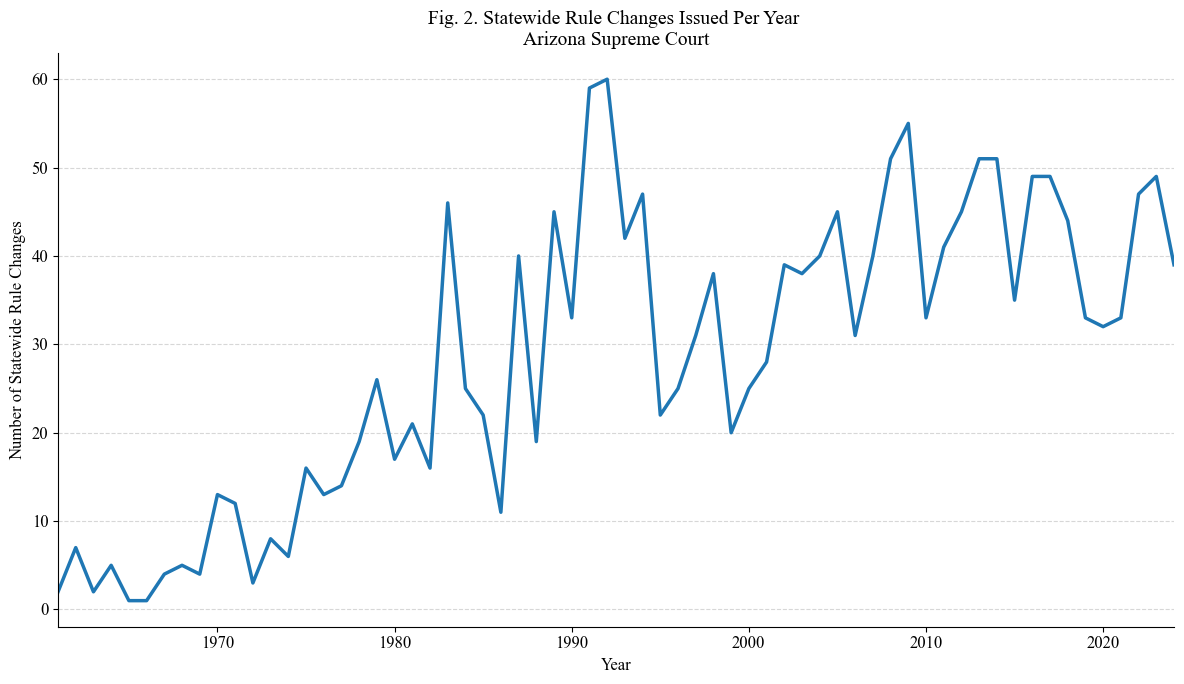

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# LOAD DATA
# ============================================================

BASE_DIR = Path.cwd().parent
file_path = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies_llm_regex.xlsx"

df = pd.read_excel(file_path)

# Ensure issued_year exists
if "issued_year" not in df.columns:
    df["issued_year"] = pd.to_datetime(
        df["issued_date"], errors="coerce"
    ).dt.year

# Keep years 1961+
df = df[df["issued_year"] >= 1961]

# ============================================================
# FILTER: STATEWIDE (LLM CLASSIFICATION)
# ============================================================

statewide_llm = df[df["Local Rule (LLM)"] == 0]

yearly_counts_llm = (
    statewide_llm
    .groupby("issued_year")
    .size()
    .sort_index()
)

# ============================================================
# PLOT
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
})

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    yearly_counts_llm.index,
    yearly_counts_llm.values,
    linewidth=2.5
)

ax.set_title(
    "Fig. 2. Statewide Rule Changes Issued Per Year \nArizona Supreme Court",
    fontsize=14
)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Statewide Rule Changes")

ax.set_xlim(1961, yearly_counts_llm.index.max())
ax.grid(axis="y", linestyle="--", alpha=0.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


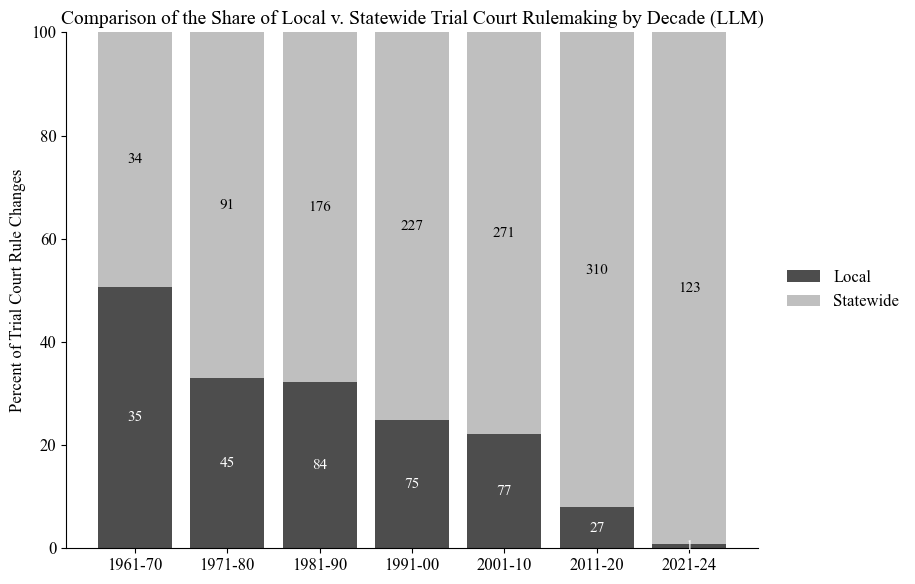

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ============================================================
# LOAD DATA #
# ============================================================

BASE_DIR = Path.cwd().parent
file_path = BASE_DIR / "files" / "order_extraction" / "extracted_rule_bodies_llm_regex.xlsx"

df = pd.read_excel(file_path)

# Ensure issued_year
if "issued_year" not in df.columns:
    df["issued_year"] = pd.to_datetime(df["issued_date"], errors="coerce").dt.year

df = df[df["issued_year"].notna() & (df["issued_year"] >= 1961)].copy()

# ============================================================
# DEFINE TRIAL COURT UNIVERSE
# ============================================================

LOCAL_COL = "Local Rule (LLM)"
ST_TRIAL_COL = "Statewide Trial Court Rule (LLM)"

df[LOCAL_COL] = pd.to_numeric(df[LOCAL_COL], errors="coerce").fillna(0).astype(int)
df[ST_TRIAL_COL] = pd.to_numeric(df[ST_TRIAL_COL], errors="coerce").fillna(0).astype(int)

trial_df = df[
    (df[LOCAL_COL] == 1) | (df[ST_TRIAL_COL] == 1)
].copy()

# ============================================================
# CREATE DECADE BINS
# ============================================================

def assign_decade(year):
    if 1961 <= year <= 1970:
        return "1961-70"
    elif 1971 <= year <= 1980:
        return "1971-80"
    elif 1981 <= year <= 1990:
        return "1981-90"
    elif 1991 <= year <= 2000:
        return "1991-00"
    elif 2001 <= year <= 2010:
        return "2001-10"
    elif 2011 <= year <= 2020:
        return "2011-20"
    elif 2021 <= year <= 2024:
        return "2021-24"
    else:
        return None

trial_df["decade"] = trial_df["issued_year"].apply(assign_decade)
trial_df = trial_df.dropna(subset=["decade"])

# ============================================================
# COUNT LOCAL VS STATEWIDE TRIAL
# ============================================================

counts = (
    trial_df
    .groupby("decade")
    .agg(
        Local=(LOCAL_COL, "sum"),
        Statewide=(ST_TRIAL_COL, "sum")
    )
)

# Ensure consistent order
decade_order = ["1961-70","1971-80","1981-90","1991-00","2001-10","2011-20","2021-24"]
counts = counts.reindex(decade_order).fillna(0)

# Shares
shares = counts.div(counts.sum(axis=1), axis=0)

# ============================================================
# PLOT STACKED BAR
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
})

fig, ax = plt.subplots(figsize=(11, 6))

bottom = np.zeros(len(shares))

colors = {
    "Local": "#4D4D4D",
    "Statewide": "#BFBFBF"
}

for col in ["Local", "Statewide"]:
    ax.bar(
        shares.index,
        shares[col] * 100,
        bottom=bottom,
        color=colors[col],
        label=col
    )
    bottom += shares[col] * 100

# ============================================================
# ADD COUNTS INSIDE BARS
# ============================================================

for i, decade in enumerate(shares.index):
    local_count = int(counts.loc[decade, "Local"])
    statewide_count = int(counts.loc[decade, "Statewide"])

    total = local_count + statewide_count
    if total == 0:
        continue

    # Local count label
    if local_count > 0:
        ax.text(
            i,
            (shares.loc[decade, "Local"] * 100) / 2,
            f"{local_count}",
            ha="center",
            va="center",
            color="white",
            fontsize=11
        )

    # Statewide count label
    if statewide_count > 0:
        ax.text(
            i,
            shares.loc[decade, "Local"] * 100 +
            (shares.loc[decade, "Statewide"] * 100) / 2,
            f"{statewide_count}",
            ha="center",
            va="center",
            color="black",
            fontsize=11
        )

# ============================================================
# FORMATTING
# ============================================================

ax.set_ylabel("Percent of Trial Court Rule Changes")
ax.set_ylim(0, 100)

ax.set_title(
    "Comparison of the Share of Local v. Statewide Trial Court Rulemaking by Decade (LLM)",
    fontsize=14
)

# Legend outside
ax.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


